# Gelogical Image Similarity
**This is a personal ML project on [Geological Image Similarity Dataset](https://www.kaggle.com/tanyadayanand/geological-image-similarity)**  

### BACKGROUND
A geology research company wants to create a tool for identifying interesting patterns in their imagery data. This tool
will possess a search capability whereby an analyst provides an image of interest and is presented with other images
which are similar to it.

### GOAL
Task is to create the machine learning component for this image similarity application. The machine learning
model should return the top K images that are most similar to this image based on a single image input.

### ABOUT the DATA:
The data includes 6 different classes of 5000 28X28 RGB images (total of 29998 images)

In [4]:
# Load usefull libraries and helper functions
import os

from tqdm import tqdm

import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.image as mpimg

from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

## Load Files

In [5]:
# Initial files are in r'input\raw' directory
root_dir = 'kaggle/input'

# Get all filenames in folder: 
img_files = [os.path.join(path, name) for path, subdirs, files in os.walk(root_dir) for name in files]
print('dataset length = ', len(img_files))
print('First 5 files:', img_files[0:5])
print()
# Dataset consists of 6 folders each containing around 5k photographs
subfolders = [f.path for f in os.scandir(root_dir) if f.is_dir()]
for subfolder in subfolders:
    print(subfolder.split('\\')[-1], ':', len(os.listdir(subfolder)), 'images')

dataset length =  29998
First 5 files: ['kaggle/input\\andesite\\012L6.jpg', 'kaggle/input\\andesite\\01ITR.jpg', 'kaggle/input\\andesite\\01LQQ.jpg', 'kaggle/input\\andesite\\0230P.jpg', 'kaggle/input\\andesite\\02741.jpg']

andesite : 5000 images
gneiss : 5000 images
marble : 4998 images
quartzite : 5000 images
rhyolite : 5000 images
schist : 5000 images


## Preview the Images

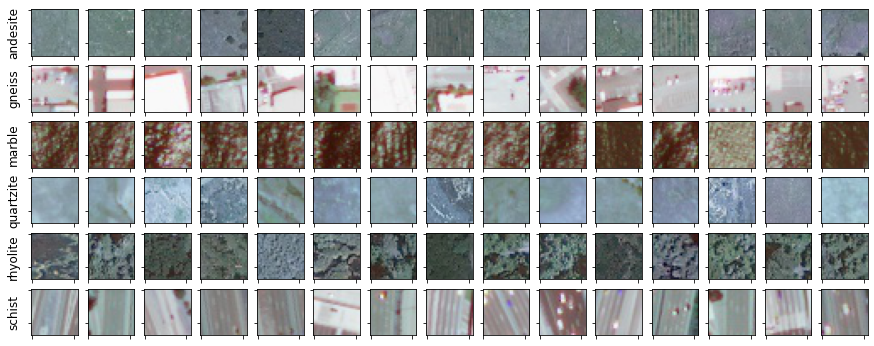

In [6]:
# Let's preview some randomly selected images of each class
n_show = 15

subfolders = [f.path for f in os.scandir(root_dir) if f.is_dir()]

fig, axes = plt.subplots(len(subfolders), n_show, figsize = (n_show,6))
# Preview images:
for row_idx, subfolder in enumerate(subfolders):    
    filenames = [f.path for f in os.scandir(subfolder)]   
    files_to_preview = random.sample(filenames, n_show)
    for col_idx, path in enumerate(files_to_preview):
        image = mpimg.imread(path)
        axes[row_idx, col_idx].imshow(image)
        axes[row_idx, col_idx].set_xticklabels([])
        axes[row_idx, col_idx].set_yticklabels([])

# Set labels:
for ax, row in zip(axes[:,0], subfolders):
    ax.set_ylabel(row.split('/')[-1], rotation=90, size='large')

plt.show()

## Create PyTorch Dataset from the Data

In [7]:
# Let's transform our dataset to torch datasets:

class GeologicalDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, root_dir, transform=None, train=True):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.train = train
        
        img_names_list = [os.path.join(path, name) for path, subdirs, files in os.walk(root_dir) for name in files]
        label_to_idx = {
            'andesite': 0,
            'gneiss': 1,
            'marble': 2,
            'quartzite': 3,
            'rhyolite': 4,
            'schist': 5
            }
        labels_list = [label_to_idx[os.path.join(path, name).split('/')[-2]]
                       for path, subdirs, files in os.walk(root_dir)
                       for name in files
                      ]
        
        img_names_train, img_names_test, labels_train, labels_test = train_test_split(
            img_names_list,
            labels_list,
            test_size=0.1,
            shuffle=True,
            random_state=42
        )

        if self.train == True:
            self.img_names = img_names_train
            self.labels = labels_train
        else:
            self.img_names = img_names_test
            self.labels = labels_test
            
    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):        
        image = mpimg.imread(self.img_names[idx])
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)

        return image, label

In [8]:
# Create transforms for train and test
    # All data transformed to Tensor and Normalized (for each channel) - see the parameters in the next cell
    # random horizontal and vertical flips used for train
train_transform = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    #transforms.RandomRotation(degrees=(0,360)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5080, 0.5196, 0.5195],
                         std=[0.1852, 0.1995, 0.2193])
])

test_transform = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5080, 0.5196, 0.5195],
                         std=[0.1852, 0.1995, 0.2193])
])

In [9]:
train_set = GeologicalDataset(root_dir = root_dir,transform=train_transform, train = True)
test_set = GeologicalDataset(root_dir = root_dir,transform=test_transform, train = False)

print('train_set:', len(train_set))
print('test_set:', len(test_set))

batch_size = 1024

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

train_set: 26998
test_set: 3000


## Create CNN Architecture
### Output for the penultimate layer (embedding) is also provided as output

In [10]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        
        self.nn = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Linear(in_features=2304, out_features=512),
            nn.Dropout2d(0.25),
            nn.Linear(in_features=512, out_features=128),
            )

        self.linear = nn.Linear(in_features=128, out_features=6)
        
    def forward(self, x):
        embedding = self.nn(x)
        x = self.linear(embedding)
        return embedding, x
        
model = CNN()
print(model)

CNN(
  (nn): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten()
    (9): Linear(in_features=2304, out_features=512, bias=True)
    (10): Dropout2d(p=0.25, inplace=False)
    (11): Linear(in_features=512, out_features=128, bias=True)
  )
  (linear): Linear(in_features=128, out_features=6, bias=True)
)


## Instantiate the Model and Load Last Training Weights

In [11]:
model = CNN()

try: model.load_state_dict(torch.load('model_state_dict.pth'))
except: pass

loss_func = nn.CrossEntropyLoss()

learning_rate = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cpu



## Train

In [20]:
%%time
# Train the model

writer = SummaryWriter()
                                  
num_epochs = 2

model = model.to(device)

for epoch in range(num_epochs):
    
    train_accuracy_epoch=[]
    for train_batch_idx, (images, labels) in enumerate(train_loader):
        model.train()
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()

        _, outputs = model(images)        
        predictions = torch.max(outputs, 1)[1]
        
        train_accuracy = accuracy_score(predictions.cpu().numpy(), labels.cpu().numpy())
        train_accuracy_epoch.append(train_accuracy)
        

        loss = loss_func(outputs, labels)                
        loss.backward()        
        optimizer.step()  
        

    avg_train_accuracy_epoch = torch.mean(torch.FloatTensor(train_accuracy_epoch))
    writer.add_scalar("Train_accuracy", avg_train_accuracy_epoch, epoch)
          
    # At the end of epoch - evaluate test set accuracy
    test_accuracy_epoch=[]
    for test_batch_idx, (images, labels) in enumerate(test_loader):
        model.eval()
        images = images.to(device)
        labels = labels.to(device)
        
        _, outputs = model(images)
        predictions = torch.max(outputs, 1)[1]
        test_accuracy = accuracy_score(predictions.cpu().numpy(), labels.cpu().numpy())
        test_accuracy_epoch.append(test_accuracy)        
    
    avg_test_accuracy_epoch = torch.mean(torch.FloatTensor(test_accuracy_epoch))
    writer.add_scalar("Test_accuracy", avg_test_accuracy_epoch, epoch)
    
    print('Epoch: ', epoch,
          '  Train accuracy:', avg_train_accuracy_epoch.item(),
          '  Test accuracy:', avg_test_accuracy_epoch.item()
          )

writer.flush()

# run in the terminal to see the progress: 
# tensorboard --logdir runs

Epoch:  0   Train accuracy: 0.9817002415657043   Test accuracy: 0.9860572814941406
Epoch:  1   Train accuracy: 0.9819000363349915   Test accuracy: 0.9830291271209717
Wall time: 1min 50s


In [ ]:
# Save the trained weights of the model
# torch.save(model.state_dict(), 'model_state_dict.pth')

## Embeddings

In [21]:
def get_embedding(file, model):
    image = mpimg.imread(file)
    image = test_transform(image)
    image = image.unsqueeze(0)
    model.eval()
    with torch.no_grad():
        emb, _ = model(image)
    return emb.numpy()

## Calculate Embeddings for all Images

In [22]:
%%time
image_embeddings = np.zeros((len(img_files), 128))
for idx, file in enumerate(img_files):
    image_embeddings[idx] = get_embedding(file, model=model)
print(image_embeddings.shape)

(29998, 128)
Wall time: 1min 25s


## Select Random Test Image

kaggle/input\schist\ABU1H.jpg


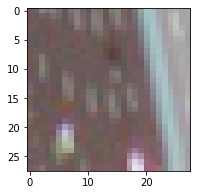

In [23]:
# Select random image from test
random_file = random.choice(img_files)

# Get the embedding for this image
emb = get_embedding(random_file, model=model)

print(random_file)
plt.rcParams["figure.figsize"] = (3,3)
image = mpimg.imread(random_file)
plt.imshow(image)
plt.show()

## Calculate pairwise similarities between the selected image and all images 

In [24]:
similarities = cosine_similarity(emb, image_embeddings)

## Preview K-Most Similar Images to the Selected Image

kaggle/input\schist\ABU1H.jpg


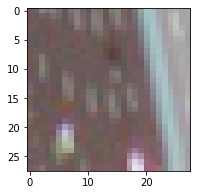

kaggle/input\schist\TGZGP.jpg


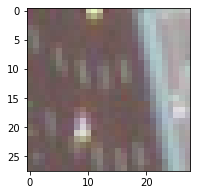

kaggle/input\schist\82AOB.jpg


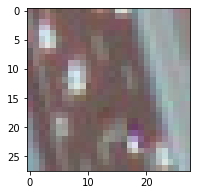

kaggle/input\schist\2TO7E.jpg


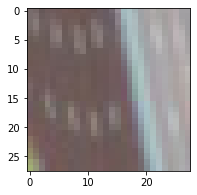

kaggle/input\schist\O7KZ0.jpg


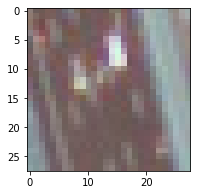

In [25]:
# Select top n-similar file indeces
K=5
ids = np.flip(similarities.argsort()[0])[0:K]

for index in ids:
    image = img_files[index]
    print(image)
    image = mpimg.imread(image)
    plt.imshow(image)
    plt.show()

No wonder that the first image found is the same image that was randomly selectet - that's a good check that everything is working fine. If the new file is loaded, this function will preview K-closest files